# PRÁCTICA 1 - Preprocesamiento de datos y evaluación de modelos de clasificación/regresión

### Francisco Martínez Esteso y Miguel Ángel Cantero Víllora

---

Es esta primera práctica vamos a completar un estudio acerca del algoritmo ZeroR, OneR y un árbol de clasificación sobre las bases de datos pima_diabetes y wisconsin, para posteriormente poder analizar y comparar los resultados obtenidos.

Empezaremos por cargar las librerias necesarias y configurar la librería matploit:

In [4]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

import base64

In [5]:
%matplotlib inline
mpl.rcParams["figure.figsize"] = "8, 4"
import warnings
warnings.simplefilter("ignore")

También vamos a definir una *semilla* la cuál nos puede ser útil para generar casos aleatorios en nuestra libreta y que más tarde podamos recuperar estos resultados y por tanto hacer nuestros experimentos reproducibles:


In [6]:
seed = 6666
np.random.seed(6666)

------------

## El conjunto de datos wisconsin

La base de datos wisconsin proporcionado por el profesor para la práctica es un conjunto de datos formado por unas variables predictoras continuas tales como clumpThickness, cellSize, CellShape, marginalAdhesion, epithelialSize, bareNuclei, blandChromatin, normalNucleoli y mitoses. 
También cuenta con un identificador autoincrementativo para cada instancia o caso llamado patiendId a modo de identificador. Por último nos encontramos con una variable clase discreta con un conjunto dominio igual a {benign, malignant}.  del grado de peligro que puede tener un paciente ante un conjunto de células.

En conjunto tratan de predecir el grado de peligro que tiene una conjunto de células del cuerpo clasificandolas de acuerdo a la variable clase.

Cargar el fichero CSV como base de datos en la variable bd_wisconsin:

In [7]:
bd_wisconsin = pd.read_csv("./data/wisconsin.csv", dtype={"label": 'category'})

Para comprobar que la base de datos se carga correctamente ejecutamos la función sample para ver un número determinado de instancias aleatorias, en nuestro caso cuatro casos:

In [8]:
bd_wisconsin.sample(4)

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label
693,694,3,1,1,2,3,NaN,1,1,1,benign
681,682,4,3,1,1,2,1.0,4,8,1,benign
212,213,6,8,7,5,6,8.0,8,9,2,malignant
657,658,10,10,10,7,9,10.0,7,10,10,malignant


In [13]:
# Vemos el dominio de la variable clase "label":
bd_wisconsin.label.cat.categories

Index(['benign', 'malignant'], dtype='object')

------------


# Análisis exploratorio


A continuación y antes de proceder al estudio del algoritmo vamos a ocupar un tiempo a observar y analizar el conjunto de datos con el que trabajamos *bd_wisconsin*. 
Para ello comprobamos el tamaño de la base de datos con la que trabajamos para hacernos una idea del volumen de datos que poseemos.
También podemos visualizar el número de variables con el que contamos y su tipo.

Para ello ejecutamos unas cuantas líneas iniciales:

In [7]:
print( "Número de casos o instancias:", len(bd_wisconsin))
print( "Tamaño de la base de datos (matriz):", bd_wisconsin.shape )
print( "Número total de celdas en nuestra base de datos: ", bd_wisconsin.size )

Número de casos o instancias: 699
Tamaño de la base de datos (matriz): (699, 11)
Número total de celdas en nuestra base de datos:  7689


In [8]:
# Información de la base de datos
bd_wisconsin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
patientId           699 non-null int64
clumpThickness      699 non-null int64
cellSize            699 non-null int64
CellShape           699 non-null int64
marginalAdhesion    699 non-null int64
epithelialSize      699 non-null int64
bareNuclei          667 non-null float64
blandChromatin      699 non-null int64
normalNucleoli      699 non-null int64
mitoses             699 non-null int64
label               699 non-null category
dtypes: category(1), float64(1), int64(9)
memory usage: 55.4 KB


A continuación analizaremos de manera individual cada variable a través de algunas gráficas univariadas para conocer un poco mejor su distribución, frecuencia e intentar eliminar posibles outliers o datos anómalos.

Para ello primero generamos una función que nos permita generar las gráficas pertinentes que necesitemos posteriormente:

In [9]:
# Función generación gráficas
def gMultipleHistogram(targetdf):
    target_noclass = targetdf.drop('label', 1)
    g = sns.FacetGrid(pd.melt(target_noclass), col="variable", sharey=False, sharex=False, col_wrap=5)
    g.map(sns.distplot, "value");

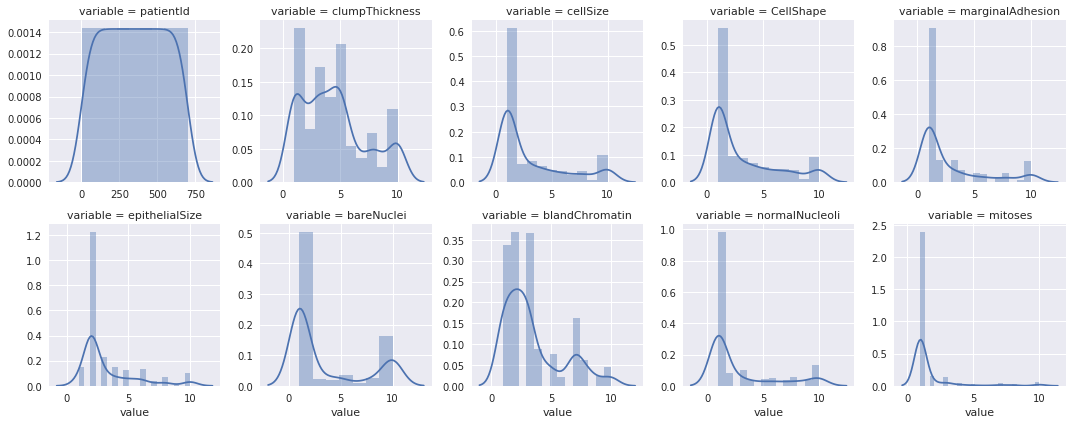

In [10]:
gMultipleHistogram(bd_wisconsin)

También podemos analizar la frecuencia de la variable discreta *label* a través de un diagrama de barras. Para ello creamos la función:

In [11]:
def gSingleBarplot(targetDf, targetVar):
    sns.countplot(data=targetDf, x=targetVar)

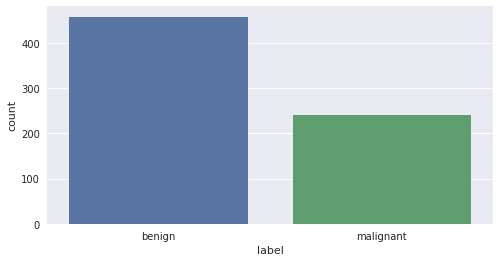

In [12]:
gSingleBarplot(bd_wisconsin, "label")

Como podemos ver la variable clase no esta balanceada, ya que existen más casos o instancias clasificadas con la clase *benign*

In [13]:
def gPairPlot(targetDf):
    sns.pairplot(targetDf, hue="label");

ValueError: max must be larger than min in range parameter.

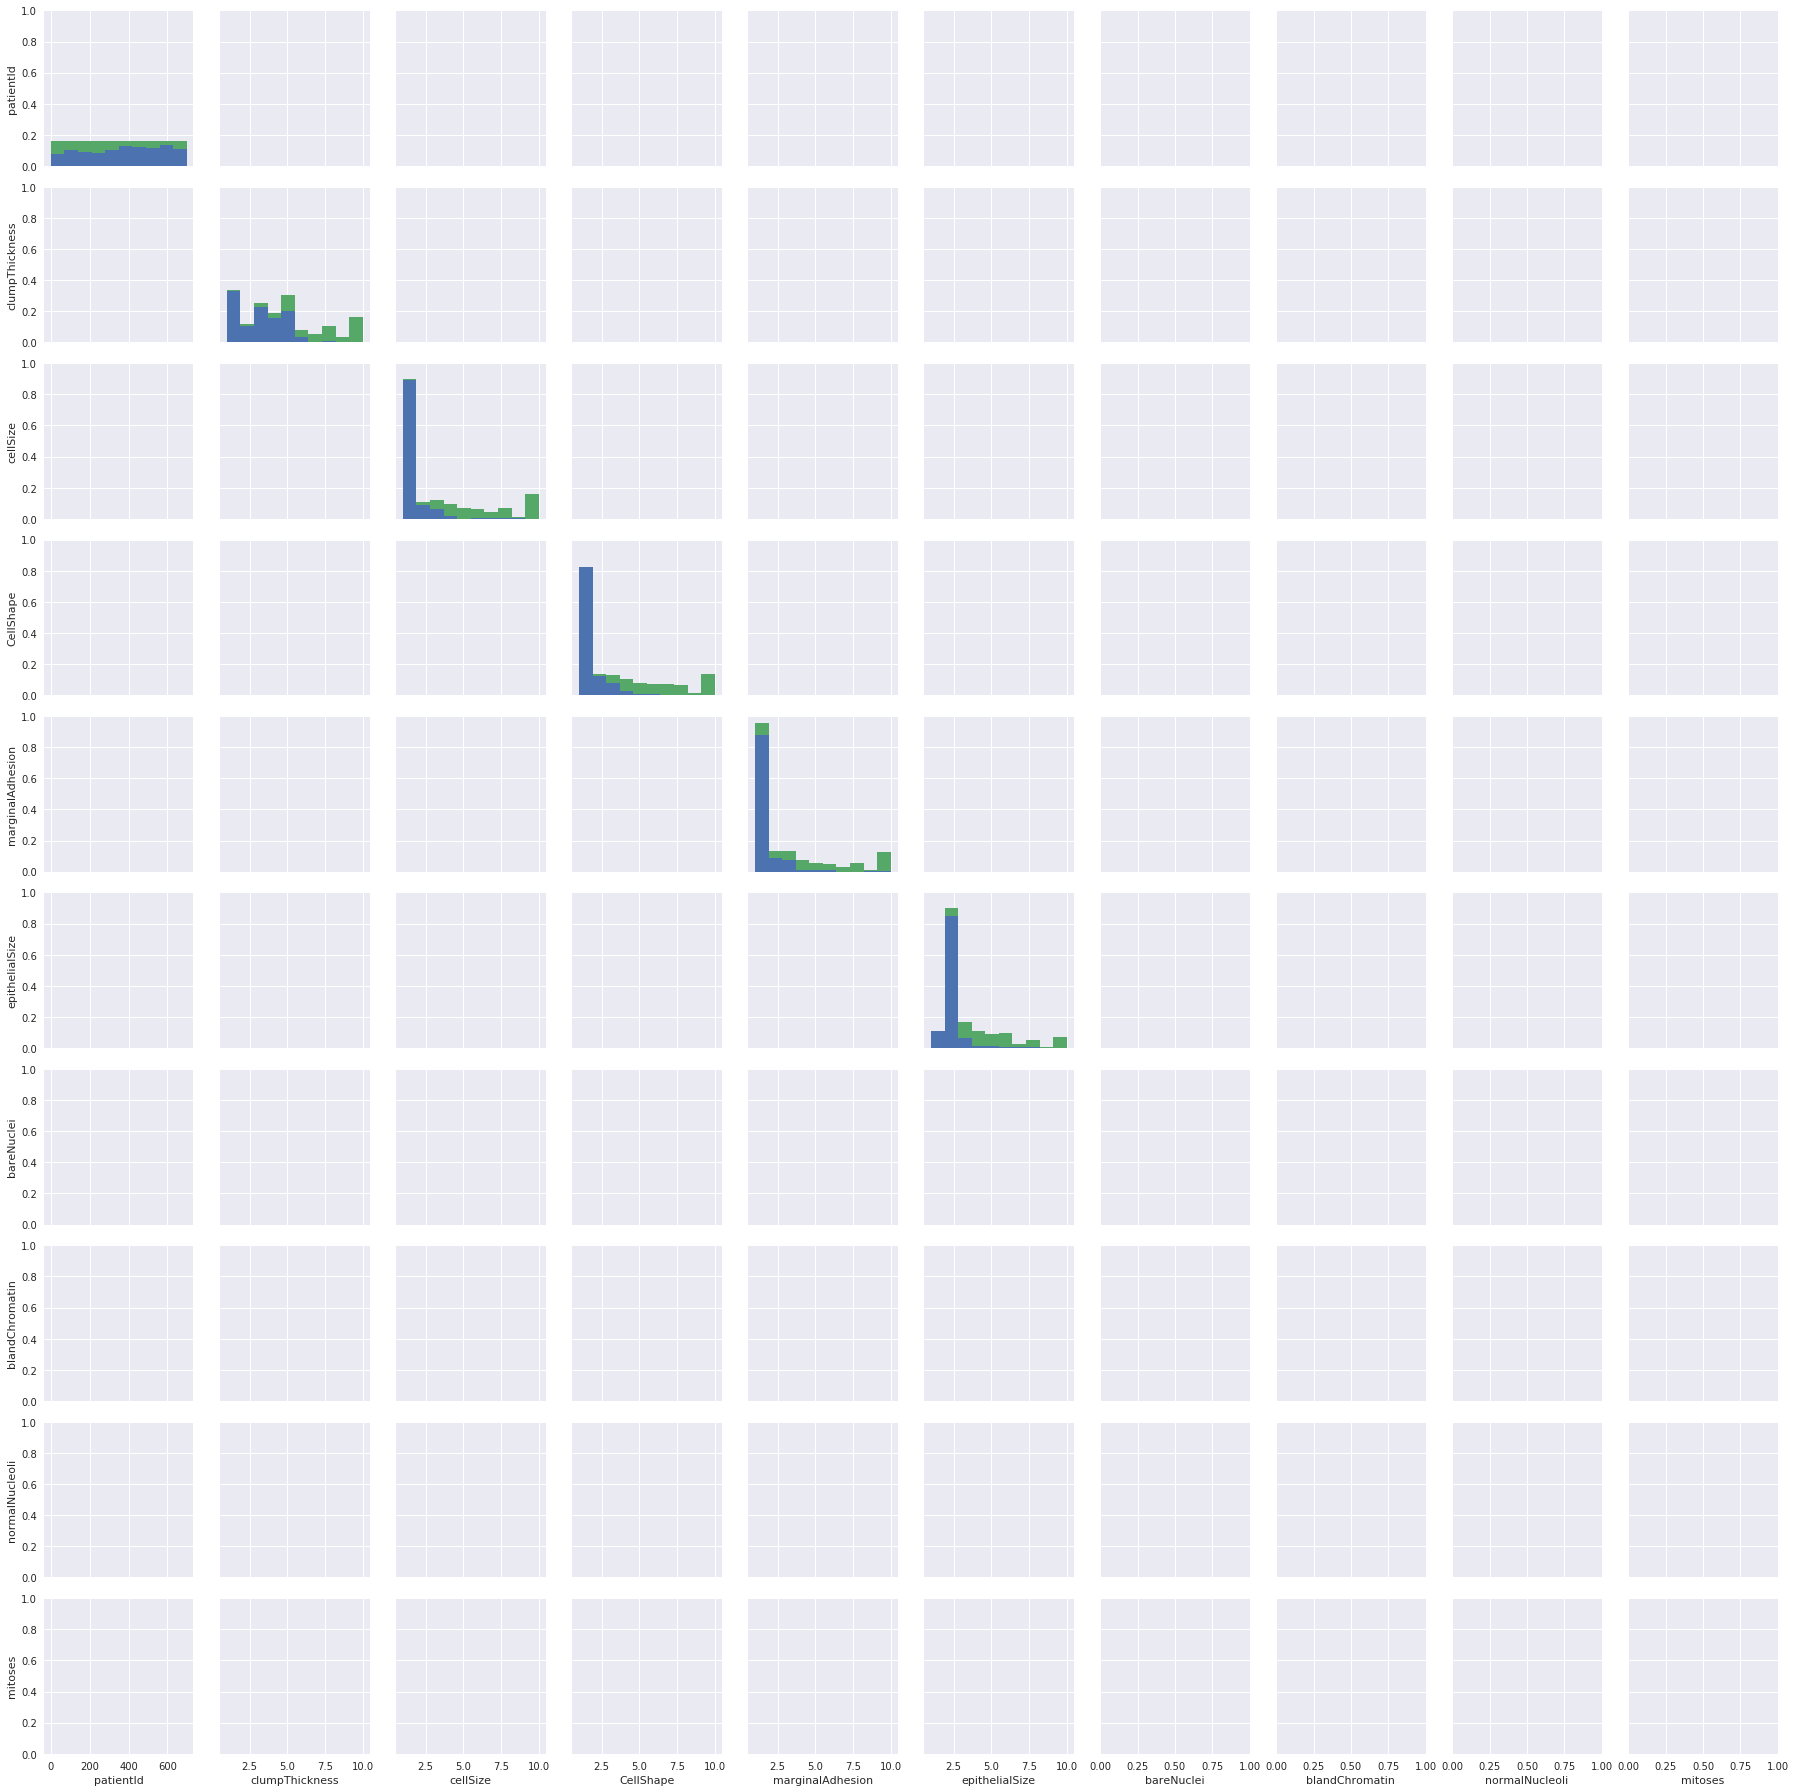

In [14]:
# DANGER!! Nos arroja un error, pero que no cunda el pánico, lo tenemos todo bajo control.
gPairPlot(bd_wisconsin)


Como vemos la generación de la gráfica del tipo nube de puntos o scatterplot nos arroja un error, el cuál nos dice que existen datos perdidos o outliers en alguna de nuestra variables de tipo NaN.

Para asegurarnos ejecutamos los siguientes comandos:


In [ ]:
bd_wisconsin.describe()

Como vemos fijándonos en la fila *count* la variable **bareNuclei** tiene 667 instancias dentro de la base de datos, que sin embargo vimos que cuenta con 699 ejemplos anteriormente.

Por lo tanto tratamos de solucionar este problema preprocesando la base de datos insertando valores concretos, en nuestro caso la media, en el lugar de los valores perdidos (NaN):

------------

## Holdout balanceado

Antes de introducir valores perdidos, lo que haremos sera usar un proceso de holdout balanceado para conseguir partir nuestra base de datos en dos partes que usaremos como conjunto de entrenamiento y conjunto de test, de manera que nos queden conjuntos balanceados, es decir, con el mismo número de variables de clase, para ello aplicamos una estratificación a nuestro dataset.

A través del paquete *scikit-learn* separaremos primero en nuestro dataset las variables de la clase: 

In [16]:
atributos = bd_wisconsin.drop('label', 1)
label = bd_wisconsin['label']

Ahora usamos la función *train_test_split* para generar cuatro particiones de aributos y clase para los conjuntos de test y train:


In [17]:
from sklearn.model_selection import train_test_split
train_atts, test_atts, train_label, test_label = train_test_split( 
    atributos, # Dataset con los atributos
    label, # Vector/dataset con la clase
    test_size=0.3, # Proporcion de test
    random_state=seed, # Semilla
    stratify=label) # Variable a estratificar

Ahora regeneramos nuestros conjuntos de entrenamiento y test:

In [18]:
WisconsinTraining = train_atts.assign(label = train_label)
WisconsinTest = test_atts.assign(label = test_label)

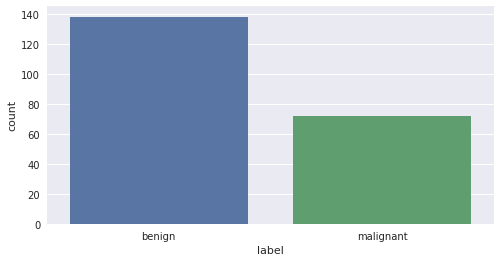

In [19]:
gSingleBarplot(WisconsinTest, "label")

Comprobamos que efectivamente a través de la estratificación nuestros conjuntos de test y training tienen un número proporcional de datos o instancias de acuerdo a la variable clase *label*.

## Inserción de valores perdidos

Una vez separado a traves de un proceso de holdout balanceado nuestro dataset en conjunto de entrenamiento y test, lo que hacemos es obtener un vector de las medias de las variables de la base de datos con la función *.mean* del conjunto de entrenamiento.

A continuación con la función *fillna* insertamos esas medias en lugar de los valores perdidos NaN del conjunto de entrenamiento y de test, siguiendo las pautas marcadas por el profesor acerca de la duda que surgió en el foro de la asignatura: 

In [20]:
# Obtenemos el vector de medias de las variables
medias = WisconsinTraining.mean()

# Con la función fillna insertamos los valores
WisconsinTraining = WisconsinTraining.fillna(medias)
WisconsinTest = WisconsinTest.fillna(medias)

Comprobamos ahora como nuestra base de datos cuenta ahora con los 669 registros totales en la variable bareiNuclei:

In [21]:
WisconsinTraining['bareNuclei'].count() + WisconsinTest['bareNuclei'].count()

699

------------

## Terminando nuestro análisis exploratorio

Ahora seguimos con nuestro análisis multivariado de la base de datos generando de nuevo la gráfica tipo nube:

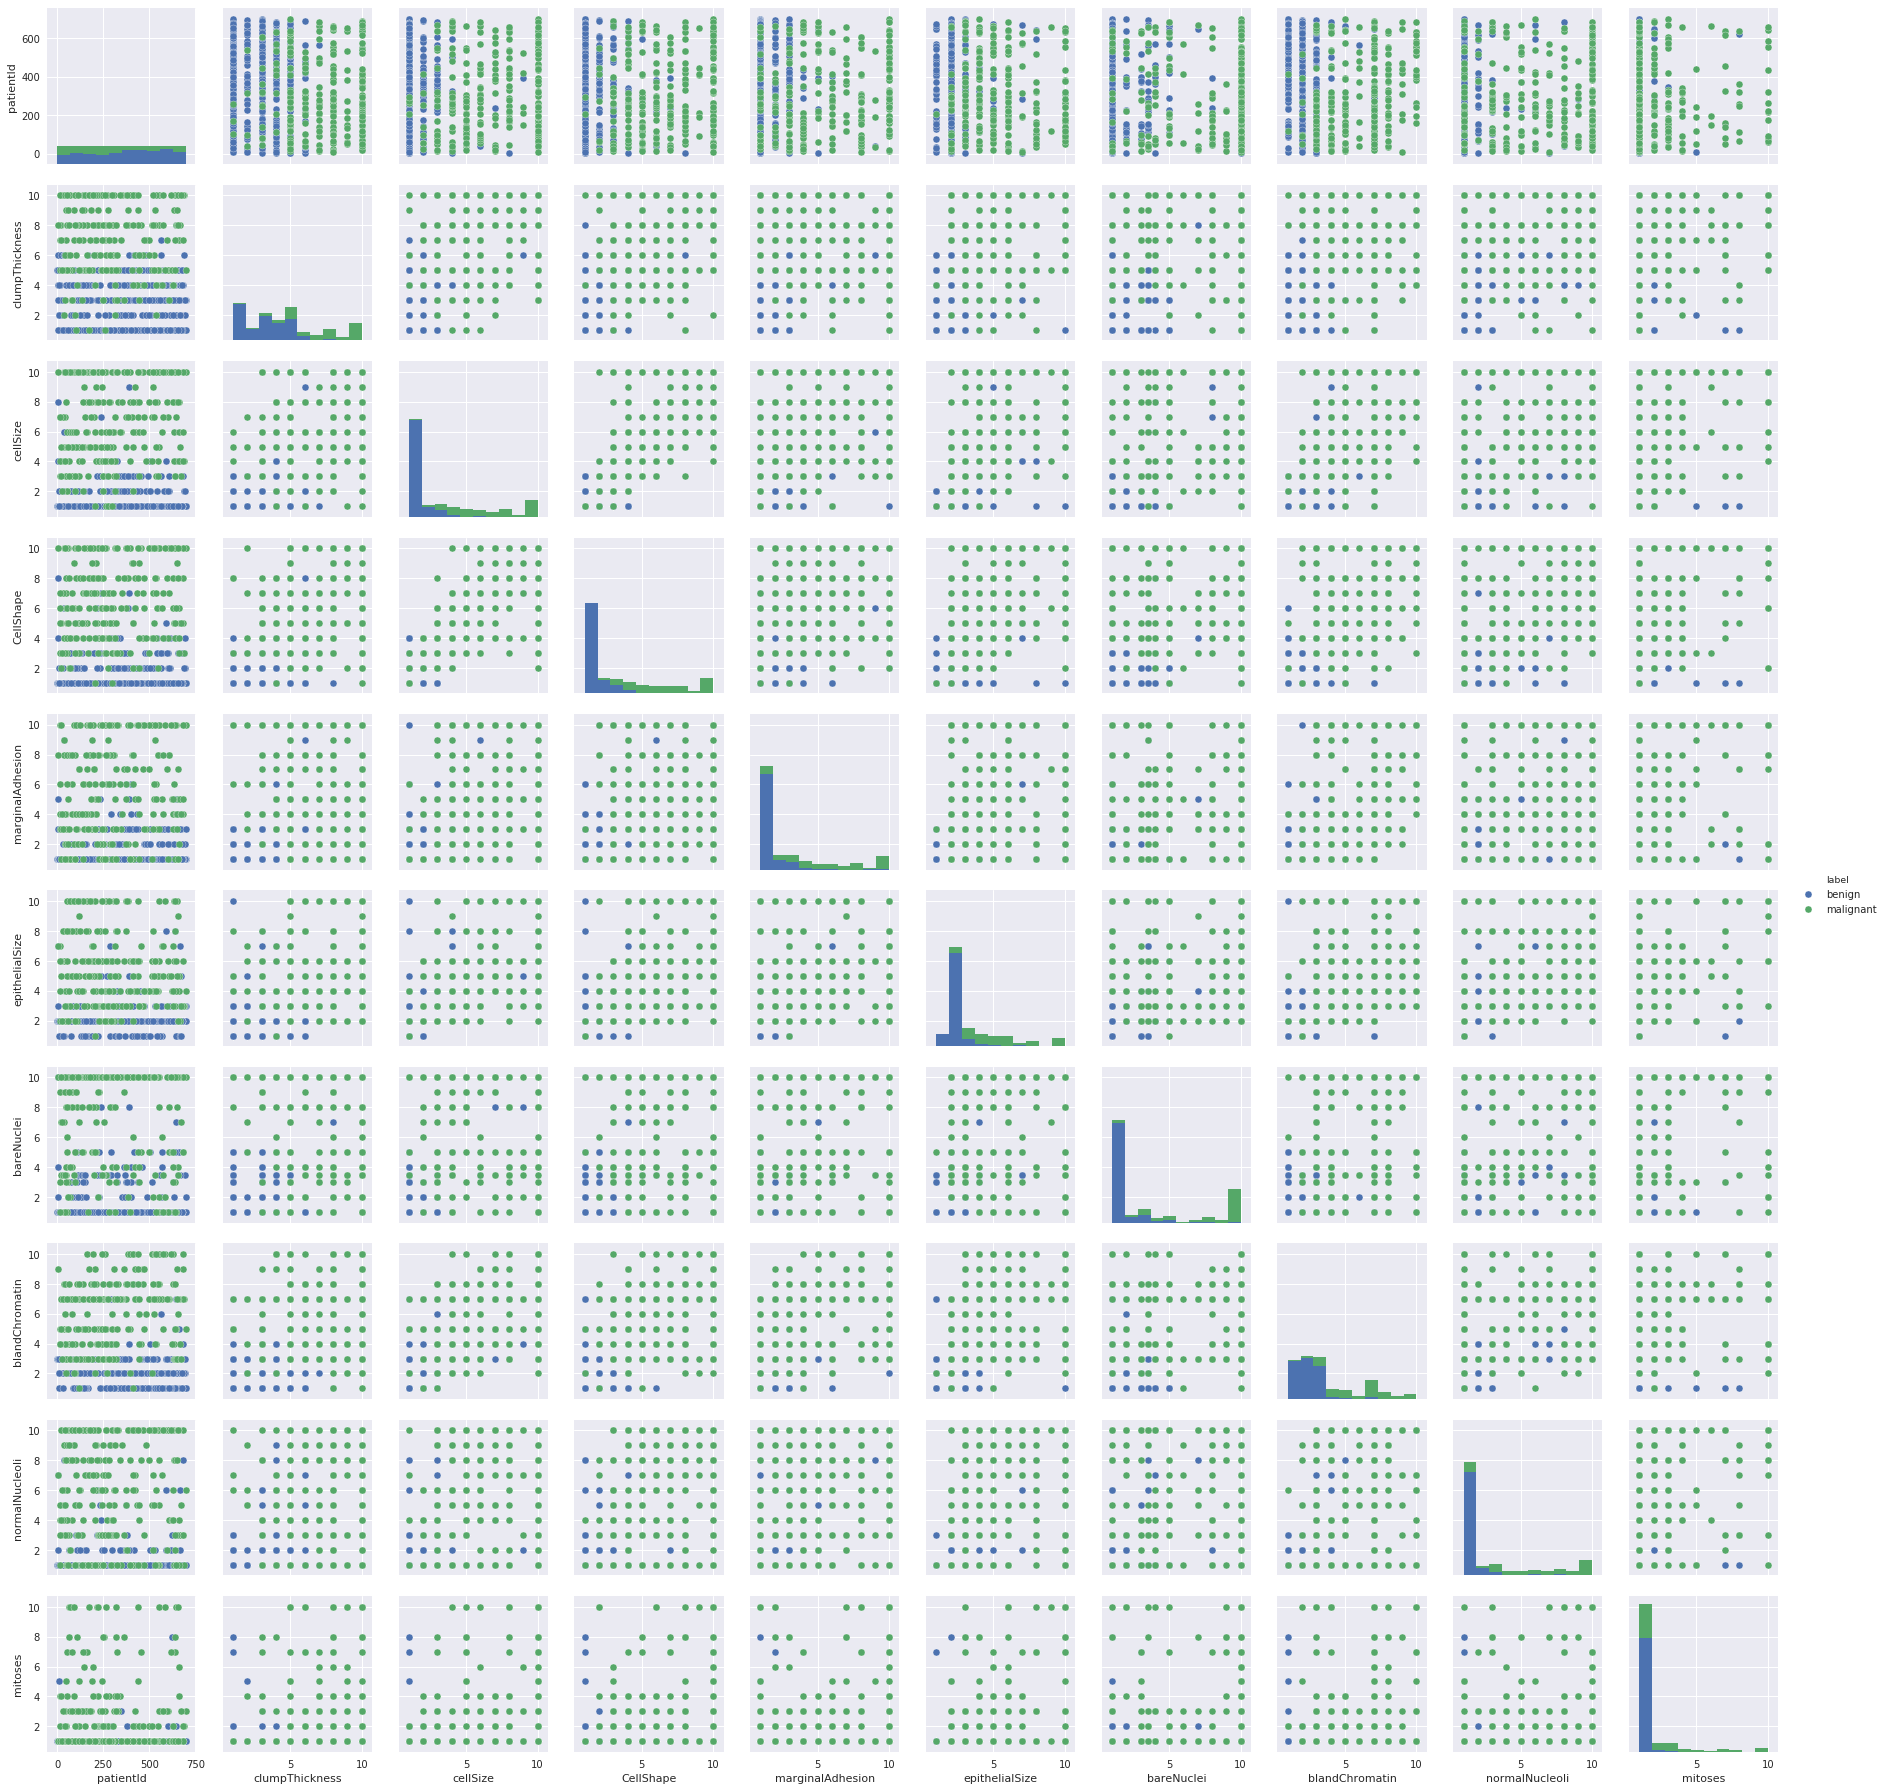

In [22]:
gPairPlot(WisconsinTraining.append(WisconsinTest))

Podemos ver que el tamaño del gráfico alcanza unas dimensione considerables debido a que compara de manera cruzada todas las variables, en nuestro caso diez.

También podemos observar que en ninguna de las variables podemos dividir su gráfico uniformemente de manera que separemos las clases perfectamente.

Tampoco observamos datos perdidos que sean candidatos a ser tratados, por lo que pasaremos a analizar nuestro dataset con algunos algoritmos de clasificación.

---

# Implementación clasificador ZeroR

Para comenzar a clasificar nuestros dataset empezaremos por el más trivial de todos, el clasificador ZeroR. Basicamente consiste en una función que asigna a los nuevos casos el valor de la clase predominante.

Este clasificador nos puede ser útil como baseline o punto de partida al evaluar la dificultad de una base de datos.

Para ello completamos la implementación ya dada del algoritmo ZeroR:

In [23]:
def trainZeroR(trainingData):
    # We first learn the parameters, aka, the most probable class
    # Tip! get the class variable mode and take the first value
    majorClass = trainingData.label.mode()[0] #1
    
    # Now we create and return the classifier function
    def classifier( data ):
        return data.assign( prediction = majorClass ) #2
    
    return classifier


En una primera aproximación vamos a entrenar y validar sobre un dataset único *bd_wisconsin* y posteriormente lo haremos sobre nuestros conjuntos de train y test obtenidos del proceso de holdout para poder obtener una comparación:


In [24]:
# Primero entrenamos el clasificador
zeroRclassifier = trainZeroR(bd_wisconsin)

# Ahora predecimos las variables clase
df_predicted = zeroRclassifier(bd_wisconsin)

# Analizamos la base de datos a partir de 5 ejemplos aleatorios.
df_predicted.sample(5)

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label,prediction
43,44,3,7,7,4,4,9.0,4,8,1,malignant,benign
319,320,8,10,5,3,8,4.0,4,10,3,malignant,benign
151,152,1,1,1,2,1,3.0,1,1,7,benign,benign
638,639,5,3,5,1,8,10.0,5,3,1,malignant,benign
47,48,9,5,8,1,2,3.0,2,1,5,malignant,benign


In [25]:
pd.crosstab(df_predicted['label'], df_predicted['prediction'])

prediction,benign
label,
benign,458
malignant,241


In [26]:
# Primero comparamos ambas comlumnas:
comparison = df_predicted[df_predicted['label'] == df_predicted['prediction'] ]
# TP: Contamos los aciertos:
accuracy = len(comparison) / len(df_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6552217453505007


---

Ahora vamos a ejecutar el mismo algoritmo clasificador ZeroR pero sobre las bases de datos de train y test:

In [27]:
# Primero entrenamos el clasificador con el conjunto train
zeroRclassifier = trainZeroR(WisconsinTraining)

# Ahora predecimos las variables clase
df_predicted = zeroRclassifier(WisconsinTest)

# Analizamos la base de datos a partir de 5 ejemplos aleatorios.
df_predicted.sample(5)

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label,prediction
11,12,2,1,1,1,2,1.0,2,1,1,benign,benign
525,526,5,7,10,6,5,10.0,7,5,1,malignant,benign
668,669,4,1,1,1,3,1.0,2,2,1,benign,benign
233,234,6,3,3,5,3,10.0,3,5,3,benign,benign
378,379,10,10,10,7,10,10.0,8,2,1,malignant,benign


In [28]:
pd.crosstab(df_predicted['label'], df_predicted['prediction'])

prediction,benign
label,
benign,138
malignant,72


In [29]:
# Primero comparamos ambas comlumnas:
comparison = df_predicted[df_predicted['label'] == df_predicted['prediction'] ]
# TP: Contamos los aciertos:
accuracy = len(comparison) / len(df_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6571428571428571


Como vemos el *accuracy* obtenido en este caso es muy parecido al anterior, ligeramente superior. 
De esta manera separando el dataset en train y test estamos haciendo buenas prácticas para no sobreentrenar el modelo, de manera que cuando clasifiquemos nuevos ejemplos a partir del modelo, no sobreajuste.

---

# Implementación clasificador OneR

A continuación vamos a completar la implementación ya dada por el profesor en la práctica para conseguir construir un algoritmo de clasificación OneR, el cuál a partir de unos datos de entrada genera una función de clasificación.

Como esqueleto general del algoritmo tenemos:

In [30]:
# El hyperparámetro nbins = 1 actua como un algoritmo ZeroR si todas las variables son continuas.
def trainOneR(trainingData, nbins = 1, debug = True):
    # Debug: 
    if debug:
        print("-----------------------------------")
        print("Training OneR")
        print("-----------------------------------")
        print("attribute\terror")
    # ------------------------------------
    # Loop maximization variables
    best_attribute = ''
    best_partitions = []
    best_classes = []
    best_error =  float("inf")
    
    # We discretize each attribute and compute its error
    for att in trainingData.columns.values: 
        # We must ignore the class variable
        if att == 'label': continue
        # First we generate the partitions
        (attribute, bins) = pd.cut(trainingData[att], bins=3, retbins=True)
        # The we must compute the error
        tab = pd.crosstab(attribute, trainingData['label'])
        error = sum( [ sum(f) - max(f) for f in tab.values ] )
        # We can show each variable individual error
        if debug:
            print(att, "\t", error)
        # ----------------------------------------

        # Lastly we compare if this attribute is better than the previous local optima
        if (error < best_error):
            # If that is the case we store it as the current local optima
            best_attribute  = att
            best_partitions = bins[1:]
            # We must store the majority class for each interval in order to assign it
            # during classification
            best_classes = [ tab.columns[f.argmax()] for f in tab.values ]
            best_error = error
    # Now we generate the classifier function regarding the previous parameters
    def classifier( testData ):
        # It simply assigns the majority class for each interval
        # For that we can use an auxiliar function to check which interval the current value
        # for the optimal attribute belongs to and assign the stored majority class
        def assignClass( attValue ):
            for i in range(nbins):
                if attValue <= best_partitions[i]:
                    return best_classes[i]
        # Now we apply the previous function to all the instances in the dataset
        # Remember that when using map in python3 we must cast the result as list
        prediction = list(map( assignClass, testData[best_attribute] ))
        return testData.assign( prediction = prediction )
    
    print("-----------------------------------")
    return classifier

In [31]:
# Entrenamos bd_wisconsin
oneRclassifier = trainOneR(bd_wisconsin, nbins=len(bd_wisconsin.label.unique()))

# Validamos bd_wisconsin
df_predicted = oneRclassifier(bd_wisconsin)

df_predicted.sample(5)

-----------------------------------
Training OneR
-----------------------------------
attribute	error
patientId 	 241
clumpThickness 	 120
cellSize 	 73
CellShape 	 72
marginalAdhesion 	 118
epithelialSize 	 121
bareNuclei 	 59
blandChromatin 	 89
normalNucleoli 	 109
mitoses 	 207
-----------------------------------


,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label,prediction
29,30,3,1,1,1,1,1.0,2,1,1,benign,benign
71,72,1,1,4,1,2,1.0,2,1,1,benign,benign
549,550,10,5,10,3,5,8.0,7,8,3,malignant,None
122,123,2,1,1,1,2,1.0,3,1,1,benign,benign
427,428,4,1,1,1,2,1.0,1,1,1,benign,benign


In [32]:
pd.crosstab(df_predicted['label'], df_predicted['prediction'])

prediction,benign,malignant
label,,
benign,424,10
malignant,44,27


In [33]:
comparison = df_predicted[df_predicted['label'] == df_predicted['prediction'] ]

accuracy = len(comparison) / len(df_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6452074391988555


Como vemos tenemos un buen *accuracy* o precisión, sin embargo al usar todo el conjunto de nuestro DataSet tanto para entrenar como para validar, lo que estamos haciendo es sobreajustar o sobreentrenar nuestro DataSet o base de datos.

Esto puede resultar en que nuestro algoritmo acabe generalizando frente a nuevos datos reales en un futuro. Podemos desprendernos de este error separando nuestros datos para entrenar y validar con dos conjuntos distintos:

---

Ahora en un caso más real, usando los conjuntos de entrenamiento y test creados a partir de nuestro dataset, ejecutamos de nuevo el algoritmo OneR y observamos los cambios en la precisión o *accuracy*:

In [34]:
# Entrenamos WisconsinTraining
oneRclassifier = trainOneR(WisconsinTraining, nbins=len(WisconsinTraining.label.unique()))

# Validamos WisconsinTest
df_predicted = oneRclassifier(WisconsinTest)

df_predicted.sample(5)

-----------------------------------
Training OneR
-----------------------------------
attribute	error
patientId 	 169
clumpThickness 	 90
cellSize 	 52
CellShape 	 50
marginalAdhesion 	 81
epithelialSize 	 91
bareNuclei 	 49
blandChromatin 	 59
normalNucleoli 	 74
mitoses 	 147
-----------------------------------


,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label,prediction
496,497,2,1,1,1,1,1.0,1,1,1,benign,benign
487,488,4,1,1,1,2,1.0,2,1,1,benign,benign
124,125,3,1,1,1,2,1.0,2,2,1,benign,benign
198,199,1,1,1,1,2,1.0,2,1,1,benign,benign
19,20,7,3,2,10,5,10.0,5,4,4,malignant,None


In [35]:
pd.crosstab(df_predicted['label'], df_predicted['prediction'])

prediction,benign,malignant
label,,
benign,131,4
malignant,16,9


In [36]:
comparison = df_predicted[df_predicted['label'] == df_predicted['prediction'] ]

accuracy = len(comparison) / len(df_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6666666666666666


Obeservamos fácilmente que los resultados usando el holdout correctamente son ligeramente mejores, esto es debido a la estratificación realizada para intentar balancear las clases dentro de los conjuntos de train y test.

Aunque seguramente en entornos reales donde tengamos que probar nuestros modelos con casos reales, la primera aproximación entrenando y validando con todo el conjunto de datos acabe sobreajustando sus clasificaciones.

---

# Clasificación con scikit-learn

Para terminar utilizaremos un árbol de clasificación con ayuda de la librería *scikit-learn*. Para ello importaremos algunas funciones específicas:

In [37]:
from sklearn import tree
model = tree.DecisionTreeClassifier(random_state=seed)

Creamos las estructuras de datos necesarias para entrenar el modelo en sklearn referentes a los atributos y las clases:

In [38]:
features = WisconsinTraining.drop('label',1)
labels = WisconsinTraining['label']

In [39]:
# Entrenamos el modelo con la función fit.
classifier = model.fit(features, labels)

Es importante quitar la información de la clase del conjunto de test antes de evaluarlo:

In [40]:
testFeatures = WisconsinTest.drop('label',1)
prediction = classifier.predict(testFeatures)

Vemos los resultados a través de la matriz de confusión y la tasa de acierto:

In [41]:
pd.crosstab(WisconsinTest['label'], prediction)

col_0,benign,malignant
label,,
benign,130,8
malignant,7,65


In [42]:
comparison = WisconsinTest[WisconsinTest['label'] == prediction]
accuracy = len(comparison) / len(WisconsinTest)
print("Accuracy:", accuracy)

Accuracy: 0.9285714285714286


Obtenemos una gran *accuracy* con un árbol de clasificación con respecto al obtenido con los algoritmos de clasificación zeroR y oneR. 
Esto puede ser debido al gran número de variables que tiene el dataset wisconsinm esto hace que un árbol de clasificación clasifique mejor sus ejemplos bajando hasta un nivel inferior que los otros dos algoritmos, o que por lo menos oneR, que no es tan trivial como su hermano pequeño.

---

---

# El conjunto de datos pima_diabetes

In [100]:
# Cargamos el dataset de pima_diabetes:
dbfile = pd.read_csv("../data/pima.csv")

In [46]:
# Mostramos las primeras filas:
dfpima.head()

,preg,plas,pres,skin,insu,mass,pedi,age,label
0,14,175,62,30,0,33.6,0.212,38,tested_positive
1,4,146,78,0,0,38.5,0.520,67,tested_positive
2,15,136,70,32,110,37.1,0.153,43,tested_positive
3,3,107,62,13,48,22.9,0.678,23,tested_positive
4,3,169,74,19,125,29.9,0.268,31,tested_positive


In [47]:
# Obtenemos una muestra aleatoria del dataset
dfpima.sample(10)

,preg,plas,pres,skin,insu,mass,pedi,age,label
73,7,83,78,26,71,29.3,0.767,36,tested_negative
419,2,112,66,22,0,25.0,0.307,24,tested_negative
121,2,108,62,32,56,25.2,0.128,21,tested_negative
48,6,80,66,30,0,26.2,0.313,41,tested_negative
465,14,100,78,25,184,36.6,0.412,46,tested_positive
222,1,81,72,18,40,26.6,0.283,24,tested_negative
182,1,81,74,41,57,46.3,1.096,32,tested_negative
25,3,129,92,49,155,36.4,0.968,32,tested_positive
281,1,111,94,0,0,32.8,0.265,45,tested_negative
296,2,157,74,35,440,39.4,0.134,30,tested_negative


----------------------------------------------------------------------
## Análisis exploratorio
A continuación se muestran unos histogramas que representan cómo se distribuye cada variable. Con esto podremos ver que valores son los que más se repiten para cada variable. Por ejemplo, vemos que la moda para la variable edad es 20.

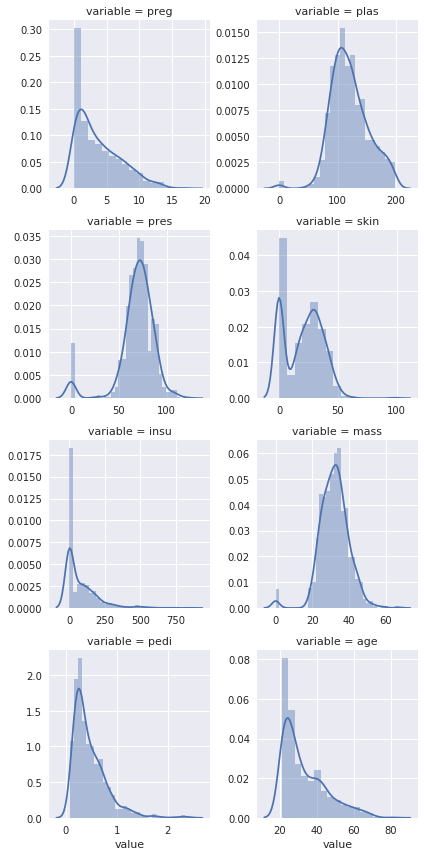

In [48]:
targetDf = dfpima

# Primero eliminamos la columna con la variable clase
target_noclass = targetDf.drop('label', 1)

# Ahora generamos un histograma múltiple
g = sns.FacetGrid(pd.melt(target_noclass), col="variable", sharey=False, sharex=False, col_wrap=2)
g.map(sns.distplot, "value");

Poodemos ver que las variables 'plas', 'pres', 'mass' muestran distribuciones con tendencia central en forma de campana. Tanto en 'pres' como en 'mass' observamos la presencia de valores atípicos o valores perdidos que se han establecido como 0 que rompen con la continuidad de la gráfica.

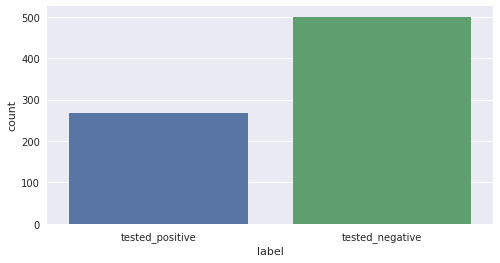

In [95]:
# Parametros:
targetDf = dfpima

# Mostramos la distribución de la variable clase:
sns.countplot(data=targetDf, x="label")

Vemos que el número de casos de la clase tested_negative es mayor que el de la clase tested_postive. Nos encontramos con el problema no balanceado en el que tenemos el doble de casos estudiados que dan negativo y por lo tanto del que tenemos más información.

Ahora vamos a analizar los patrones que se dan entre las variables para ayudar a mejorar nuestros resultados de clasificación. Mostramos un gráfico de cada una de las relaciones entre las variables. Utilizaremos una nube puntos en el que cada punto corresponderá con un caso de la base de datos y en cada eje representaremos un atributo predictor. Además, vamos incluir información adicional, coloreando cada instancia acorde a la clase a la que pertenece.

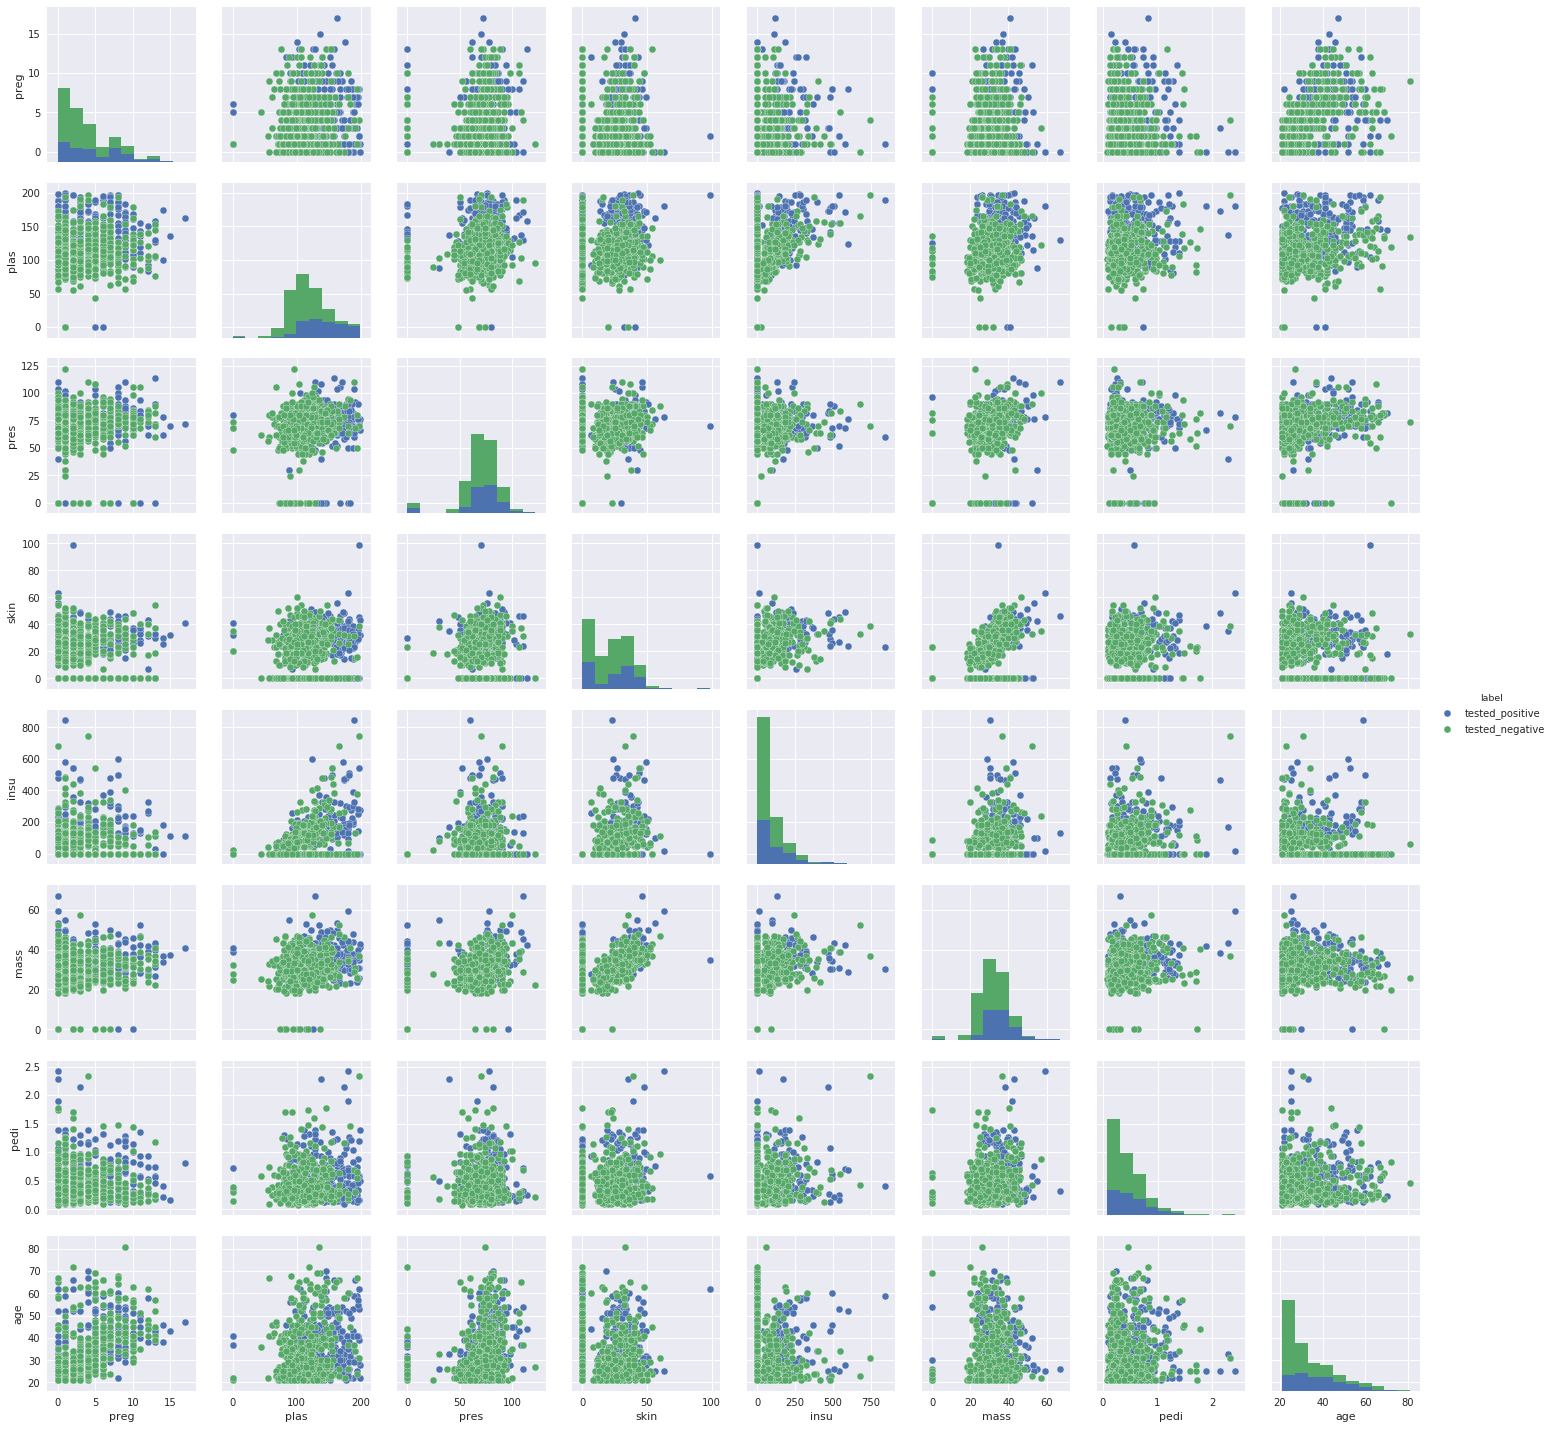

In [50]:
# Parametros:
targetDf = dfpima

# Este grafico muestra para cada par de variables un scaterplot y un histograma para cada variable individual.
sns.pairplot(targetDf, hue="label");

Analizando las gráficas, no se puede decir que haya ningún atributo que por sí solo separe perfectamente las clases. Sin embargo si analizamos las relaciones entre variables si que podemos clasificar las clases mejor. Por ejemplo 'pres' y 'plas' tienen cierta relación ya que, aunque por si solas no nos dicen nada, juntas nos ayudan a clasificar mejor las clases ya que nos dejan por un lado la mayor parte de una clase y por otro la mayor parte de la otra.

Analizar grandes cantidades de datos a mano puede no ser rentable cuando tenemos enromes cantidades de variables, ya que el número de gráficas a analizar asciende a nºvariables^2. Es por ello que primero es normal utilizar técnicas de estadística que nos permitan analizar numéricamente los atributos.

In [51]:
dfpima.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


---------------------------------------------------------------
## Clasificadores triviales zeroR y oneR
### Clasificador zeroR
El clasificador zeroR es el clasificador más trivial de todos. Básicamente consiste en una función que asigna a los nuevos casos la clase predominante. Este clasificador es inútil en la mayoría de los casos, pero nos servirá como evaluación inicial o baseline a la hora de evaluar la dificultad de un dataset concreto o la efectivadad de un modelo.

Vamos a implementar de manera manual un clasificador zeroR para la base de datos pima. En este caso, nos dará siempre la clase predominante que es tested_negative. Implementaremos un clasificador como una función que crea una nueva columna en nuestro dataset llamada prediction indicando la clase que asigna dicho clasificador a la instancia correspondiente.

In [52]:
# La funcion assign nos permite crear una nueva columna en funcion de las anteriores:

# Por ejemplo, sumando dos valores:
prueba1 = dbfile.assign( nuevaCol = dbfile.preg + dbfile.plas )
print(prueba1.head(), "\n")

# O asignando un booleano mediante comparacion:
prueba2 = dbfile.assign( nuevaCol = dbfile.insu >= 80.0 )
print(prueba2.head(), "\n")

   preg  plas  pres  skin  insu  mass   pedi  age            label  nuevaCol
0    14   175    62    30     0  33.6  0.212   38  tested_positive       189
1     4   146    78     0     0  38.5  0.520   67  tested_positive       150
2    15   136    70    32   110  37.1  0.153   43  tested_positive       151
3     3   107    62    13    48  22.9  0.678   23  tested_positive       110
4     3   169    74    19   125  29.9  0.268   31  tested_positive       172 

   preg  plas  pres  skin  insu  mass   pedi  age            label  nuevaCol
0    14   175    62    30     0  33.6  0.212   38  tested_positive     False
1     4   146    78     0     0  38.5  0.520   67  tested_positive     False
2    15   136    70    32   110  37.1  0.153   43  tested_positive      True
3     3   107    62    13    48  22.9  0.678   23  tested_positive     False
4     3   169    74    19   125  29.9  0.268   31  tested_positive      True 



A continuación crearemos una función que, dado un dataframe, clasifique las instancias.

In [53]:
# Creamos la función de entrenamiento que devuelve el clasificador. 

def trainZeroR(trainingData):
    # Primero obtenemos la clase mas probable. (La moda)
    claseMasProbable = trainingData['label'].mode()[0]
    
    # Ahora creamos la funcion que dado un dataset de test crea la columna de predicciones
    def classifier( testData ):
        return testData.assign( prediction = claseMasProbable )
    
    return classifier

Vamos a entrenar el clasificador con todos los datos que tenemos, y luego clasificaremos estos mismos datos, más adelante ya aplicaremos un proceso de holdout.

In [54]:
# Primero entrenamos el clasificador
zeroRclassifier = trainZeroR(dbfile)

# Ahora lo aplicamos:
dbfile_predicted = zeroRclassifier(dbfile)

# Comprobemos el resultado:
dbfile_predicted.sample(5)

,preg,plas,pres,skin,insu,mass,pedi,age,label,prediction
110,4,90,88,47,54,37.7,0.362,29,tested_negative,tested_negative
641,4,90,0,0,0,28.0,0.610,31,tested_negative,tested_negative
421,0,113,80,16,0,31.0,0.874,21,tested_negative,tested_negative
615,4,109,64,44,99,34.8,0.905,26,tested_positive,tested_negative
371,1,106,76,0,0,37.5,0.197,26,tested_negative,tested_negative


Como vemos la predicción siempre es negativa y en la muestra de 5 elementos nos sale una tasa de acierto de 1. Esto es porque este clasificador siempre devuelve la clase más probable que es la que más se repite en el dataset. Este clasificador es muy malo aunque tenga una alta tasa de acierto ya que siempre nos predecirá el mismo resultado.

Ahora vamos a calcular la matriz de confusión entre las columnas label y prediction de nuestro dataset.

In [55]:
pd.crosstab(dbfile_predicted['label'], dbfile_predicted['prediction'])

prediction,tested_negative
label,
tested_negative,500
tested_positive,268


Ahora podemos calcular el accuracy contando el número de filas en las que coinciden ambas columnas:

In [56]:
# Primero comparamos ambas comlumnas:
comparison = dbfile_predicted[dbfile_predicted['label'] == dbfile_predicted['prediction'] ]

# TP: Contamos los aciertos:
accuracy = len(comparison) / len(dbfile_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6510416666666666


Vemos que su tasa de acierto es superior al 65% siendo un clasificador trivial. Aunque sea un mal clasificador por lo explicado anteriormente, hay problemas en los que puede ayudarnos a identificar situaciones anómalas.

-------------------------------------------------------------------------
### Clasificador oneR
Con una filosfía similar a la de su homónimo más sencillo, el clasificador OneR identifica una partición potencial en el dataset que nos permita separar la clase lo mejor posible. Para ello identificará el atributo predictor más relevante y diversos puntos de corte en el caso de una variable continua. Para el caso discreto asignará a cada estado la clase más probable.
Como en el caso de los árboles de decisión o en los algoritmos de discretización supervisada, existen técnicas estadísticas muy eficaces para evaluar la relevancia de los atributos y buscar los puntos de corte óptimos.

Seguiremos un enfoque en el que discretizaremos de manera no supervisada las variables numéricas y asignaremos a cada partición la variable más probable.

Nuestra primera aproximación utilizará un enfoque de discretización por igual anchura. Para ello buscaremos el atributo que, una vez discretizado, nos ofrezca una mejor separación de la clase.

##### Discretizando
Para discretizar por igual anchura podemos utilizar la funcion pd.cut(...) [Doc]
```
pd.cut(
x : Array o variable,
bins: Numero de bins a utilizar
retbins: Poner a true para que devuelva una tupla
...
)
```
La función devuelve una tupla con la nueva variable y los bins generados:

In [57]:
# EJEMPLO DE USO:
(attribute, bins) = pd.cut(dbfile['mass'], bins=3, retbins=True)

print(attribute.sample(10))
print()
# IMPORTANTE! quitar el primer bin!
print(bins[1:])

184    (22.367, 44.733]
652    (22.367, 44.733]
747    (22.367, 44.733]
479    (22.367, 44.733]
49     (22.367, 44.733]
210    (22.367, 44.733]
77     (22.367, 44.733]
535    (22.367, 44.733]
453    (22.367, 44.733]
34     (22.367, 44.733]
Name: mass, dtype: category
Categories (3, interval[float64]): [(-0.0671, 22.367] < (22.367, 44.733] < (44.733, 67.1]]

[ 22.36666667  44.73333333  67.1       ]


----------------------------------------------------------------------------------------------------
#### Prueba con un atributo:
Vamos a probar a discretizar en 3 bins el atributo mass:

In [58]:
# Discretizamos
(attribute, bins) = pd.cut(dbfile['mass'], bins=3, retbins=True)

Ahora vamos a comprobar cómo de bien clasificaría esta partición del atributo por separado. Para ello vamos a crear una matriz conforme a la clase:

In [59]:
tab = pd.crosstab(attribute, dbfile['label'])
tab

label,tested_negative,tested_positive
mass,,
"(-0.0671, 22.367]",49,2
"(22.367, 44.733]",437,244
"(44.733, 67.1]",14,22


Para clasificar, asignaríamos a cada partición la clase mayoritaria, por lo que escogeríamos el valor máximo para cada fila. Según esta matriz podemos ver que la primera partición (-0.0671, 22.367] identificada muy bien la variable mass, con muy poco error con respecto a la otra.

En cambio las otras dos introducen mas error ya que la diferencia entre las dos clases es menor, lo que se traduce a mayor numero de clasificaciones erróneas.

Una buena medida para evaluar esta partición sería la suma de todos los ejemplos que serían mal clasificados conforme a las particiones, es decir, la clase minoritaria en cada una de las particiones:

In [60]:
2+244+14

260

In [61]:
# O calculado usando numpy:
# iterando por filas, sumamos todos los valores y restando el maximo.
# Luego sumamos la lista resultante
sum( [ sum(f) - max(f) for f in tab.values ] )

260

In [62]:
# O calculado usando numpy:
# iterando por filas, sumamos todos los valores y restando el maximo.
# Luego sumamos la lista resultante
sum( [ sum(f) - max(f) for f in tab.values ] )

260

Para saber la mejor clase, podemos mirar la tabla y quedarnos con el índice máximo

In [63]:
# iteramos por filas, usamos argmax para obtener el indice del elemento mas alto y
# consultamos el vector de nombres de tab columns
[ tab.columns[f.argmax()] for f in tab.values ]

['tested_negative', 'tested_negative', 'tested_positive']

Probad a cambiar el código anterior para analizar otro atributo diferente ¿La partición que genera el mejor o peor?, ¿ concuerda con la gráfica anterior?

In [64]:
# Discretizamos
(attribute, bins) = pd.cut(dbfile['skin'], bins=3, retbins=True)
tab = pd.crosstab(attribute, dbfile['label'])
sum( [ sum(f) - max(f) for f in tab.values ] )

267

Clasifica peor ya que el numero de clasificaciones erroneas es mayor.

---------
#### Ahora implementamos el clasificador siguiendo la misma filosofia que usamos para ZeroR
Creamos una función de entrenamiento que dado unos datos de entrada genere una función de clasificación.

In [65]:
# Creamos la función de entrenamiento que devuelve el clasificador. 
def trainOneR(trainingData):
    # Debug: 
    print("-----------------------------------")
    print("Entrenando Clasificador OneR")
    print("-----------------------------------")
    print("atributo\terror")
    # ------------------------------------
    
    # Obtenemos el numero de clases, usando unique() para usarlo como numero de bins
    numPartitions = len( trainingData['label'].unique() )

    # Variables para comparar los atributos entre si
    best_attribute = ''
    best_partitions = []
    best_classes = []
    best_error =  float("inf")

    # Para cada atributo discretizamos y calculamos la metrica de error
    for att in trainingData.columns.values: 
        # Si el atributo es la clase lo ignoramos:
        if att == 'label': continue

        # Generamos las particiones
        (attribute, bins) = pd.cut(trainingData[att], bins=numPartitions, retbins=True)

        # Ahora calculamos la metrica de error, generando la matriz de separacion y sumando
        # los errores:
        tab = pd.crosstab(attribute, trainingData['label'])
        error = sum( [ sum(f) - max(f) for f in tab.values ] )

        # Debug: Vamos a imprimir algo de informacion para monitorizar el algoritmo
        print(att, "\t", error)
        # ----------------------------------------
        
        # Por ultimo comprobamos si este atributo es mejor que lo anteriores:
        if (error < best_error):
            # En caso afirmativo lo guardamos:
            best_attribute  = att
            best_partitions = bins[1:]
            # Hay que guardar la clase mayoritaria para cada bin, para eso usaremos la
            # tabla de clasificacion
            best_classes = [ tab.columns[f.argmax()] for f in tab.values ]
            best_error = error

    # Ahora generamos la funcion de clasificacion con el mejor atributo
    def classifier( testData ):
        # Simplemente asignamos para cada particion la clase correspondiente
        # Para ello usamos una función auxiliar que compruebe a que particion
        # corresponde el valor del atributo seleccionado:
        def assignClass( attValue ):
            for i in range(numPartitions):
                if attValue <= best_partitions[i]:
                    return best_classes[i]

        # Ahora la aplicamos al atributo selecionado:
        prediction = list(map( assignClass, testData[best_attribute] ))

        return testData.assign( prediction = prediction )
    
    print("-----------------------------------")
    return classifier

Usamos el algoritmo de manera análoga a como usamos en su momento ZeroR.

In [66]:
# Primero entrenamos el clasificador
oneRclassifier = trainOneR(dbfile)

# Ahora lo aplicamos:
dbfile_predicted = oneRclassifier(dbfile)

# Comprobemos el resultado:
dbfile_predicted.sample(5)


-----------------------------------
Entrenando Clasificador OneR
-----------------------------------
atributo	error
preg 	 258
plas 	 268
pres 	 268
skin 	 268
insu 	 262
mass 	 268
pedi 	 267
age 	 268
-----------------------------------


,preg,plas,pres,skin,insu,mass,pedi,age,label,prediction
682,9,91,68,0,0,24.2,0.200,58,tested_negative,tested_positive
52,3,96,78,39,0,37.3,0.238,40,tested_negative,tested_negative
199,1,87,60,37,75,37.2,0.509,22,tested_negative,tested_negative
624,5,97,76,27,0,35.6,0.378,52,tested_positive,tested_negative
513,6,103,72,32,190,37.7,0.324,55,tested_negative,tested_negative


#### Calculamos el error de clasificación

In [67]:
pd.crosstab(dbfile_predicted['label'], dbfile_predicted['prediction'])

prediction,tested_negative,tested_positive
label,,
tested_negative,462,38
tested_positive,220,48


También podemos repetir el cómputo de la tasa de acierto (accuracy), donde observamos que es mucho más alta que en el caso de ZeroR, tal y como esperábamos.

In [68]:
# Primero comparamos ambas comlumnas:
comparison = dbfile_predicted[dbfile_predicted['label'] == dbfile_predicted['prediction'] ]

# TP: Contamos los aciertos:
accuracy = len(comparison) / len(dbfile_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6640625


Como observamos, comparandolo con el accuracy del método zeroR, ha mejorado un poco. 0.6640625 > 0.6510416666666666

-----------------------------------
## Evaluación de modelos: Holdout

Hasta ahora hemos estado trabajando con todo el conjunto de datos conforme lo hemos cargado desde el fichero. Esto se considera una muy mala práctica ya que todas las decisiones que tomemos, incluido el análisis exploratorio estarán sobreajustadas y serán de mala calidad al no corresponderse con el mundo real.

Desde el primer momento, es fundamental separar nuestro conjunto de datos como mínimo en dos: Una muestra de entrenamiento y una muestra de testeo, un proceso conocido como holdout. De este modo, podemos dejar el conjunto de testeo aparte a modo de instancias no observadas, para asegurarnos que todas las decisiones que tomemos puedan ser evaluadas correctamente.

Una vez en pandas, podemos aplicar un holdout partiendo directamente el dataset, para ello podemos usar la función de indexado:

In [69]:
# Supongamos un porcentaje
trainingSize = 0.6

# Calculamos el tamano de la particion
# !! Muy importante el uso de ceil, para
# redondear el indice de corte al entero superior!!
from math import ceil
cutIndex = ceil(len(dbfile) * trainingSize)

# Cortamos el dataset en dos subconjuntos:
dbfileTraining = dbfile.iloc[0:cutIndex]
dbfileTest = dbfile.iloc[cutIndex:]

# Comprobamos los tamanos:
print(len(dbfile))
print(len(dbfileTraining))
print(len(dbfileTest))

768
461
307


Como vemos nos ha cogido 461 muestras para el entrenamiento y 307 para las pruebas del dataset de 768 muestras.

Ahora es el momento de entrenar de nuevo ambos clasificadores y comprobar el resultado. Comenzaremos con el clasificador ZeroR, ahora entrenaremos con el tranining y evaluaremos con el test:

In [70]:
# Primero entrenamos el clasificador
zeroRclassifier = trainZeroR(dbfileTraining)
# Ahora lo aplicamos:
dbfile_predicted = zeroRclassifier(dbfileTest)
# Matriz de confusion:
pd.crosstab(dbfile_predicted['label'], dbfile_predicted['prediction'])

prediction,tested_negative
label,
tested_negative,200
tested_positive,107


In [71]:
# Accuracy:
# Primero comparamos ambas comlumnas:
comparison = dbfile_predicted[dbfile_predicted['label'] == dbfile_predicted['prediction'] ]
# TP: Contamos los aciertos:
accuracy = len(comparison) / len(dbfile_predicted)
print("Accuracy:", accuracy)


Accuracy: 0.6514657980456026


In [72]:
# Accuracy:
# Primero comparamos ambas comlumnas:
comparison = dbfile_predicted[dbfile_predicted['label'] == dbfile_predicted['prediction'] ]
# TP: Contamos los aciertos:
accuracy = len(comparison) / len(dbfile_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6514657980456026


En este caso la precisión también ha mejorado. En este caso debido a que la diferencia entre las clases de cada segmento ha incrementado.

Vamos a echar un vistazo a nuestro dataset de entrenamiento. Para ello repetimos las gráficas del principio.

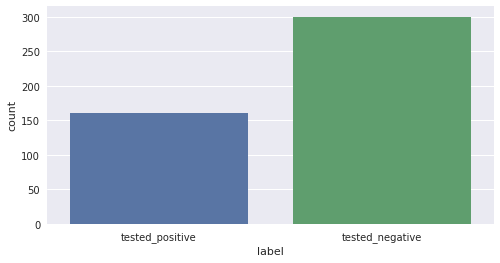

In [73]:
# Parametros:
targetDf = dbfileTraining # <<--- Cambiar el target por cualquier otro DF

# Lo siguiente que haremos es mostrar la distribución de la variable clase:
sns.countplot(data=targetDf, x="label")

Vemos que no hemos perdido ninguna clase y que mas o menos se mantienen las proporciones con respecto al dataset completo. Es por esto que la precisión obtenida es tan similar.

La primera lección del preprocesado es nunca asumir nada sobre el estado de los datos. En nuestro caso hemos tenido suerte porque los datos estaban bien mezclados y hemos obtenido unas proporciones casi idénticas, pero podríamos no haber tenido tanta suerte. De modo que antes de realizar ninguna operación sobre el conjunto de datos es razonable aplicar una randomización de los valores:

In [74]:
# Randomizamos el dataset, para ello accedemos al indice del dataframe
# y le aplicamos una funcion de permutacion con numpy
# Supongamos un porcentaje
trainingSize = 0.6

# Calculamos el tamano de la particion
cutIndex = ceil(len(dbfile) * trainingSize)

# Randomizamos el dataset, usamos un indice aleatorio y 
# la funcion reindex
randomIndex = np.random.permutation( dbfile.index )
dbfilepermdf = dbfile.reindex( randomIndex )

# Cortamos el dataset en dos subconjuntos:
dbfileTraining = dbfilepermdf.iloc[0:cutIndex-1]
dbfileTest = dbfilepermdf.iloc[cutIndex:]

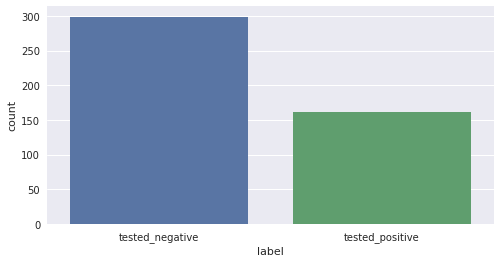

In [75]:
# Parametros:
targetDf = dbfileTraining # <<--- Cambiar el target por cualquier otro DF

# Lo siguiente que haremos es mostrar la distribución de la variable clase:
sns.countplot(data=targetDf, x="label")

Como vemos, tenemos una gran uniformidad. En este caso la diferencia no es tan apreciable porque seguramente el dataset ya estaba aleatoreizado.

Sin embargo, el resultado varia cada vez, esto es porque estamos utilizando una función aleatoria sin semilla y por ello nunca obtendremos el mismo resultado.
Esta propiedad es indeseable en muchas ocasiones, ya que muchas veces querremos ser capaces de reproducir nuestros resultados. Para ello ajustaremos una semilla para la librería numpy con la función np.random.seed

In [76]:
# En los experimentos utilizaremos siempre una semilla para poder reproducir los resultados
seed=6342
np.random.seed(6342)

Hay una última consideración a tener en cuenta a la hora de separar los datos en training y test. Muchas veces, aleatorizar los datos no es suficiente, ya que de este modo no garantizamos preservar las distribuciones de las variables, y en casos complejos podemos estar eliminando gran cantidad de información.
Es por ello que para garantizar dicha distribución solemos utilizar una técnica denominada estratificación. Con esta técnica garantizamos que para cada partición mantenemos una proporción de ejemplos de cada clase estable. Esto es aun más importante cuando nuestros datos están desbalanceados, es decir, tenemos un número de ejemplos distintos para cada clase.
Para aplicar estratificación, utilizaremos una función de particionado de los datos de scikit-learn.

Como veremos más adelante scikit separa siempre los atributos de la variable clase en todas sus operaciones, así que debemos acostumbrarnos a dividir las columnas de nuestro dataset:

In [77]:
# Dividimos el dataframe en atributos y clase
atributos = dbfile.drop('label', 1)
clase = dbfile['label']

Ahora cargamos y usamos la función train_test_split de scikit-learn para generar nuestras particiones. Esta función nos devolverá 4 particiones, correspondientes al entrenamiento y test para atributos y clase:

In [96]:
from sklearn.model_selection import train_test_split
train_atts, test_atts, train_label, test_label = train_test_split( 
    atributos, # Dataset con los atributos
    clase, # Vector/dataset con la clase
    test_size=0.4, # Proporcion de test
    random_state=seed, # Semilla
    stratify=clase) # Variable a estratificar

Ahora podemos regenerar nuestros datatasets completos para usarlos con ZeroR y OneR:

In [97]:
dbfileTraining = train_atts.assign(label = train_label)
dbfileTest = test_atts.assign(label = test_label)

Si repetimos la gráfica anterior, veremos que ahora nuestra partición de entrenamiento conserva la proporcion orginal entre las clases.

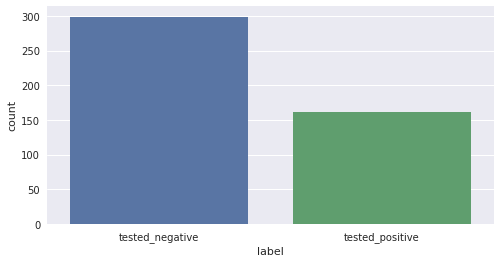

In [98]:
train = dbfileTraining
# Parametros:
targetDf = train # <<--- Cambiar el target por cualquier otro DF

# Lo siguiente que haremos es mostrar la distribución de la variable clase:
sns.countplot(data=targetDf, x="label")

------------------------
Ahora repetiremos el experimento anterior para ver si los resultados son más razonables:
#### ZeroR:

In [81]:
# Primero entrenamos el clasificador
zeroRclassifier = trainZeroR(dbfileTraining)
# Ahora lo aplicamos:
dbfile_predicted = zeroRclassifier(dbfileTest)
# Matriz de confusion:
pd.crosstab(dbfile_predicted['label'], dbfile_predicted['prediction'])

prediction,tested_negative
label,
tested_negative,201
tested_positive,107


In [82]:
# Accuracy:
# Primero comparamos ambas comlumnas:
comparison = dbfile_predicted[ dbfile_predicted['label'] == dbfile_predicted['prediction'] ]
# TP: Contamos los aciertos:
accuracy = len(comparison) / len(dbfile_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6525974025974026


**OneR**

In [83]:
# Primero entrenamos el clasificador
oneRclassifier = trainOneR(dbfileTraining)
# Ahora lo aplicamos:
dbfile_predicted = oneRclassifier(dbfileTest)
# Matriz de confusion:
pd.crosstab(dbfile_predicted['label'], dbfile_predicted['prediction'])

-----------------------------------
Entrenando Clasificador OneR
-----------------------------------
atributo	error
preg 	 146
plas 	 161
pres 	 161
skin 	 161
insu 	 159
mass 	 161
pedi 	 157
age 	 161
-----------------------------------


prediction,tested_negative,tested_positive
label,,
tested_negative,179,22
tested_positive,84,22


In [84]:
# Accuracy:
# Primero comparamos ambas comlumnas:
comparison = dbfile_predicted[dbfile_predicted['label'] == dbfile_predicted['prediction'] ]
# TP: Contamos los aciertos:
accuracy = len(comparison) / len(dbfile_predicted)
print("Accuracy:", accuracy)

Accuracy: 0.6525974025974026


Puedes asumir una reduccion en la tasa de acierto a cambio de asegurar que realizas las comprobaciones con un conjunto de datos que puedes encontrar en la vida real.

-----------------------
## Clasificación con scikit-learn

Ahora que ya hemos jugado con nuestros propios clasificadores, es hora de probar un método más competitivo y utilizar el paquete scikit-learn.

Concretamente utilizaremos un árbol de decisión, solo arañaremos el potencial de la librería en esta práctica. En las siguientes sesiones nos centraremos en como usar y ajustar este tipo de modelos.

Para lanzar el algoritmo debemos cargar la librería y usar las funciones correspondientes:

In [85]:
# Cargamos el arbol de decision
from sklearn import tree
# Iniciamos el modelo
model = tree.DecisionTreeClassifier(random_state=seed)

Para entrenar un modelo de sklearn, tenemos que pasarle por separado los atributos y la clase. Para ello creamos las siguientes estructuras:

In [86]:
features = dbfileTraining.drop('label',1)
labels = dbfileTraining['label']

Para entrenar un clasificador usaremos la función fit:

In [87]:
# Usamos fit, para aprender:
classifier = model.fit(features, labels)

Para evaluar nuevas instancias utilizaremos el modelo aprendido junto a la función predict. Es muy importante que quitemos la información de la clase del dataset de test antes de evaluarlo.

In [88]:
testFeatures = dbfileTest.drop('label',1)
prediction = classifier.predict(testFeatures)

Una ves hayamos obtenido nuestro vector de predicciones, podemos calcular la matriz de confusión y ls tasa de acierto:

In [89]:
pd.crosstab(dbfileTest['label'], prediction)

col_0,tested_negative,tested_positive
label,,
tested_negative,153,48
tested_positive,33,74


In [99]:
# Accuracy:
# Primero comparamos ambas comlumnas:
comparison = dbfileTest[dbfileTest['label'] == prediction]
# TP: Contamos los aciertos:
accuracy = len(comparison) / len(dbfileTest)
print("Accuracy:", accuracy)

Accuracy: 0.737012987012987


El resultado es una gran mejora de la precisión al utilizar esta técnica ya que hemos logrado un porcentaje de acierto de 0.737012987012987